# 1.导包

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# 2.读取数据

In [2]:
# 加载数据
train_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")
train_data = train_data.iloc[:-3] # 删除最后三行NaN值

# 3.数据预处理

In [3]:
# 数值特征
numerical_features_to_scale = ['casual', 'registered']  # 需要归一化的特征
numerical_features_no_scale = ['temp', 'atemp', 'hum', 'windspeed']  # 不需要归一化的特征
target_column = 'cnt'

# 数据预处理
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

# 初始化归一化器
scaler_cnt = MinMaxScaler()
scaler_features = MinMaxScaler()

# 归一化目标变量
scaler_cnt.fit(train_data[[target_column]])
train_data[target_column] = scaler_cnt.transform(train_data[[target_column]])
test_data[target_column] = scaler_cnt.transform(test_data[[target_column]])

# 归一化特征
scaler_features.fit(train_data[numerical_features_to_scale])
train_data[numerical_features_to_scale] = scaler_features.transform(train_data[numerical_features_to_scale])
test_data[numerical_features_to_scale] = scaler_features.transform(test_data[numerical_features_to_scale])

In [4]:
# 时间特征处理
def preprocess_time_features(data):
    data['hour_sin'] = np.sin(2 * np.pi * data['hr'] / 24.0)
    data['hour_cos'] = np.cos(2 * np.pi * data['hr'] / 24.0)
    data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7.0)
    data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7.0)
    data['season_sin'] = np.sin(2 * np.pi * data['season'] / 4.0)
    data['season_cos'] = np.cos(2 * np.pi * data['season'] / 4.0)
    data['month_sin'] = np.sin(2 * np.pi * data['mnth'] / 12.0)
    data['month_cos'] = np.cos(2 * np.pi * data['mnth'] / 12.0)
    return data
train_data = preprocess_time_features(train_data)
test_data = preprocess_time_features(test_data)

# 4.特征提取

In [5]:
# 特征列表
features = [
    'hour_sin', 'hour_cos',  # 小时周期
    'weekday_sin', 'weekday_cos',  # 周周期
    'season_sin', 'season_cos',  # 季节周期
    'month_sin', 'month_cos',  # 月份周期
    'yr', 'holiday', 'workingday', 'weathersit',  # 分类特征
    'temp', 'atemp', 'hum', 'windspeed',  # 数值特征
    'casual', 'registered'  # 归一化特征
]

X_train = train_data[features]
X_test = test_data[features]

y_train = train_data[target_column]
y_test = test_data[target_column]

# 5.划分数据集

In [6]:
# 构造时间序列数据（滑动窗口）
def create_dataset(X, y, seq_len=96, output_len=96, step=1):
    features, targets = [], []
    for i in range(0, len(X) - seq_len - output_len + 1, step):
        features.append(X.iloc[i:i+seq_len].values)
        targets.append(y.iloc[i+seq_len:i+seq_len+output_len].values)
    return np.array(features), np.array(targets)

train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=96, output_len=96)
test_dataset, test_labels = create_dataset(X_test, y_test, seq_len=96, output_len=96)

In [9]:
# 自定义数据集
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 数据加载器
train_loader = DataLoader(CustomDataset(train_dataset, train_labels), batch_size=64, shuffle=True)
test_loader = DataLoader(CustomDataset(test_dataset, test_labels), batch_size=64, shuffle=False)


# 6. 模型架构

In [10]:
# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=3, output_size=96, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 最后一个时间步
        x = self.fc(x)
        return x

# 7.训练并保存最佳模型

In [11]:
# 模型配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_dataset.shape[2]
model = LSTMModel(input_size=input_size, hidden_size=256, num_layers=3, output_size=96, dropout=0.3).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [15]:
# 修改多次实验函数
def run_experiments(model_class, train_loader, test_loader, epochs=50, num_experiments=5):
    test_losses = []  # 保存每次实验的最佳 Test Loss

    for i in range(num_experiments):
        print(f"Starting Experiment {i + 1}/{num_experiments}")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 确定目标序列长度
        target_sequence_length = train_loader.dataset[0][1].shape[0]  # 假设目标张量为 (batch_size, seq_len)
        
        # 初始化模型
        model = model_class(
            input_size=train_loader.dataset[0][0].shape[1],  # 输入特征数
            hidden_size=256,
            num_layers=3,
            output_size=target_sequence_length,  # 设置为目标序列长度
            dropout=0.3
        ).to(device)

        criterion = nn.MSELoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs)
        
        best_loss = float('inf')  # 当前实验的最佳 Test Loss
        
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)

            model.eval()
            test_loss = 0.0
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    test_loss += loss.item()
            test_loss /= len(test_loader)

            scheduler.step(test_loss)

            print(f"Experiment {i + 1}, Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
            
            # 保存最佳模型
            if test_loss < best_loss:
                best_loss = test_loss
                torch.save(model.state_dict(), f"model/lstm_short_best_model_{i+1}.pth")
                print(f"Experiment {i + 1}: Best model saved with Test Loss: {test_loss:.6f}")

        test_losses.append(best_loss)
    
    # 打印实验结果
    avg_loss = sum(test_losses) / num_experiments
    print(f"\nAll Experiments Completed!")
    print(f"Test Losses: {test_losses}")
    print(f"Average Test Loss: {avg_loss:.6f}")
    print(f"Standard Deviation of Test Loss: {np.std(test_losses):.6f}")

# 调用函数运行实验
run_experiments(
    model_class=LSTMModel, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    epochs=30, 
    num_experiments=5
)


Starting Experiment 1/5


/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Experiment 1, Epoch 1/30, Train Loss: 0.019918, Test Loss: 0.022193
Experiment 1: Best model saved with Test Loss: 0.022193
Experiment 1, Epoch 2/30, Train Loss: 0.010459, Test Loss: 0.029274
Experiment 1, Epoch 3/30, Train Loss: 0.007436, Test Loss: 0.026077
Experiment 1, Epoch 4/30, Train Loss: 0.006297, Test Loss: 0.033368
Experiment 1, Epoch 5/30, Train Loss: 0.005774, Test Loss: 0.022544
Experiment 1, Epoch 6/30, Train Loss: 0.005437, Test Loss: 0.021237
Experiment 1: Best model saved with Test Loss: 0.021237
Experiment 1, Epoch 7/30, Train Loss: 0.005179, Test Loss: 0.019992
Experiment 1: Best model saved with Test Loss: 0.019992
Experiment 1, Epoch 8/30, Train Loss: 0.004942, Test Loss: 0.022034
Experiment 1, Epoch 9/30, Train Loss: 0.004724, Test Loss: 0.017710
Experiment 1: Best model saved with Test Loss: 0.017710
Experiment 1, Epoch 10/30, Train Loss: 0.004577, Test Loss: 0.017220
Experiment 1: Best model saved with Test Loss: 0.017220
Experiment 1, Epoch 11/30, Train Loss: 

# 8. 通过模型进行预测

In [16]:
# 加载最佳模型并预测

def predict_average(models, test_loader):
    """
    使用多个模型进行预测并求平均值。

    :param models: 模型文件路径列表
    :param test_loader: 测试数据加载器
    :return: 平均预测结果和真实值
    """
    all_predictions = []

    # 遍历所有模型，逐个加载并进行预测
    for model_path in models:
        print(f"Loading model: {model_path}")
        model.load_state_dict(torch.load(model_path))  # 加载模型权重
        model.eval()

        predictions = []
        actuals = []
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(device)
                outputs = model(batch_X).cpu().numpy()  # 获取预测值
                predictions.extend(outputs)
                actuals.extend(batch_y.cpu().numpy())

        all_predictions.append(np.array(predictions))  # 将预测结果存储

    # 将所有预测结果求平均
    average_predictions = np.mean(all_predictions, axis=0)  # 逐样本求平均
    return average_predictions, np.array(actuals)

# 定义模型文件路径列表
models = [f"model/lstm_short_best_model_{i+1}.pth" for i in range(5)]

# 调用函数进行预测
average_predictions, actuals = predict_average(models, test_loader)

# 打印结果
print("Predictions shape:", average_predictions.shape)
print("Actuals shape:", actuals.shape)


Loading model: model/lstm_short_best_model_1.pth


/tmp/ipykernel_7337/4281014882.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # 加载模型权重


Loading model: model/lstm_short_best_model_2.pth
Loading model: model/lstm_short_best_model_3.pth
Loading model: model/lstm_short_best_model_4.pth
Loading model: model/lstm_short_best_model_5.pth
Predictions shape: (1969, 96)
Actuals shape: (1969, 96)


# 9.计算MSE和MAE

In [17]:
# 反归一化预测和实际值
average_predictions = scaler_cnt.inverse_transform(average_predictions)
actuals = scaler_cnt.inverse_transform(actuals)

# 每个样本的 MSE 和 MAE
mse_per_sample = np.mean((average_predictions - actuals) ** 2, axis=1)  # 每个样本的 MSE
mae_per_sample = np.mean(np.abs(average_predictions - actuals), axis=1)  # 每个样本的 MAE

# 计算均值和标准差
mse_mean = np.mean(mse_per_sample)
mse_std = np.std(mse_per_sample)
mae_mean = np.mean(mae_per_sample)
mae_std = np.std(mae_per_sample)

# 输出结果
print(f"Mean Squared Error (MSE): {mse_mean:.6f} ± {mse_std:.6f}")
print(f"Mean Absolute Error (MAE): {mae_mean:.6f} ± {mae_std:.6f}")


Mean Squared Error (MSE): 14504.678711 ± 18160.943359
Mean Absolute Error (MAE): 72.406891 ± 43.489727


# 10.绘图

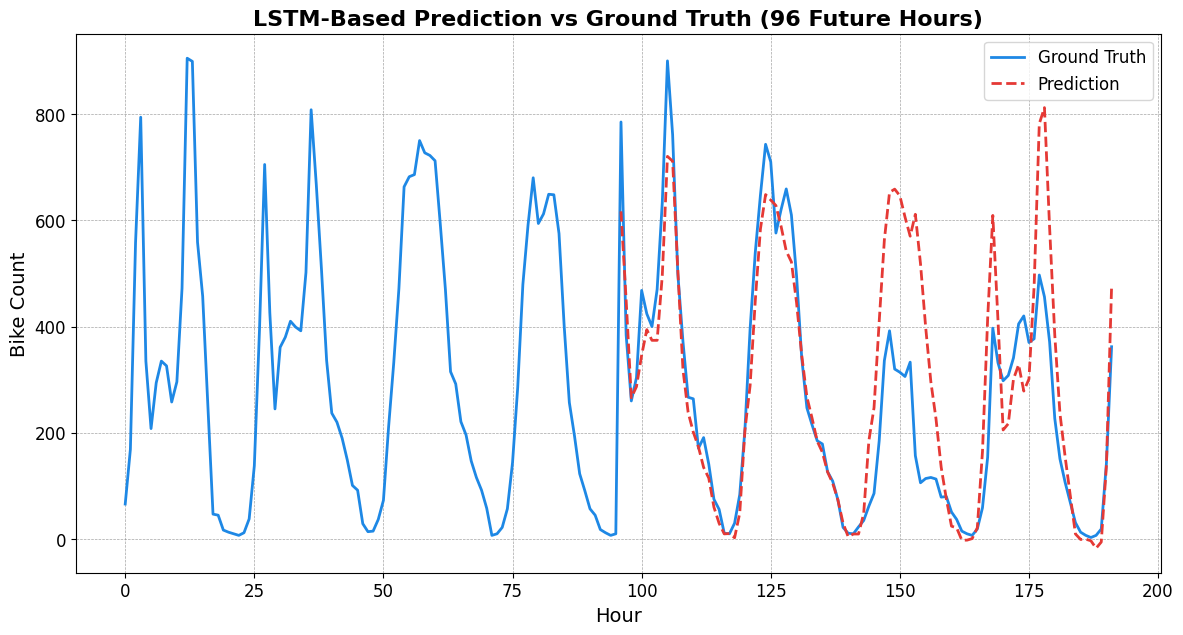

In [21]:
train_last_96 = scaler_cnt.inverse_transform(y_train.iloc[-96:].values.reshape(-1, 1)).flatten()
pred_values = np.concatenate((np.zeros(96), average_predictions[0]))
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

plt.figure(figsize=(14, 7))  # 调整图表大小

# 绘制真实值曲线
plt.plot(range(192), np.concatenate((train_last_96, actuals[0])), 
         label="Ground Truth", color="#1E88E5", linewidth=2)  # 更改为深蓝色

# 绘制预测值曲线
plt.plot(range(96, 192), average_predictions[0], 
         label="Prediction", color="#E53935", linestyle="--", linewidth=2)  # 更改为深红色

# 添加图例和标题
plt.legend(fontsize=12, loc="upper right")  # 图例在右上角
plt.title("LSTM-Based Prediction vs Ground Truth (96 Future Hours)", fontsize=16, fontweight="bold")
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Bike Count", fontsize=14)

# 调整坐标轴样式
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# 保存并展示图像
plt.savefig("bike_rental_predictions_lstm96.png", dpi=300, bbox_inches='tight')
plt.show()
